In [14]:
!pip install numpy pandas music21 matplotlib seaborn torch torchvision

import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from music21 import converter, instrument, note, chord, stream
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from music21 import environment

# Set the MuseScore paths in the music21 environment
env = environment.UserSettings()
env['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'
env['musicxmlPath'] = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'

# Set  MIDI file directory
#Extract all midi files from different folders into the "archive" folder in directory
filepath = "./archive"  

def extract_notes(midi_folder):
    notes = []
    for file in os.listdir(midi_folder):
        if file.endswith(".mid"):
            try:
                midi = converter.parse(os.path.join(midi_folder, file))
                parts = instrument.partitionByInstrument(midi)
                notes_to_parse = parts.parts[0].recurse() if parts else midi.flat.notes
                for element in notes_to_parse:
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))
            except Exception as e:
                print(f"Error processing {file}: {e}")
    return notes


# Extract notes from MIDI files
all_notes = extract_notes(filepath)



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: c:\users\user\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip


In [2]:
# Prepare sequential data for LSTM
n_vocab = len(set(all_notes))
sequence_length = 100

# Create a dictionary to convert notes to integers
note_to_int = dict((note, number) for number, note in enumerate(set(all_notes)))

network_input = []
network_output = []

# Create input sequences and the corresponding outputs
for i in range(0, len(all_notes) - sequence_length, 1):
    sequence_in = all_notes[i:i + sequence_length]
    sequence_out = all_notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# Reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# Normalize input
network_input = network_input / float(n_vocab)

network_output = pd.get_dummies(network_output).values

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(network_input, network_output, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Custom Dataset class
class MIDIDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for training and validation
train_dataset = MIDIDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = MIDIDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Epoch 1/20, Loss: 5.047450644756603
Epoch 2/20, Loss: 4.827429887484213
Epoch 3/20, Loss: 4.806050259103625
Epoch 4/20, Loss: 4.761312631075323
Epoch 5/20, Loss: 4.755905598953669
Epoch 6/20, Loss: 4.755931071422439
Epoch 7/20, Loss: 4.75580008667694
Epoch 8/20, Loss: 4.75312406077611
Epoch 9/20, Loss: 4.749327989867794
Epoch 10/20, Loss: 4.747713498660189
Epoch 11/20, Loss: 4.751196927437664
Epoch 12/20, Loss: 4.7552720220040525
Epoch 13/20, Loss: 4.755616150026127
Epoch 14/20, Loss: 4.757218045494088
Epoch 15/20, Loss: 4.760507181724092
Epoch 16/20, Loss: 4.7578672077801105
Epoch 17/20, Loss: 4.757671907739231
Epoch 18/20, Loss: 4.755213392023039
Epoch 19/20, Loss: 4.989983079987778
Epoch 20/20, Loss: 4.740181567437492


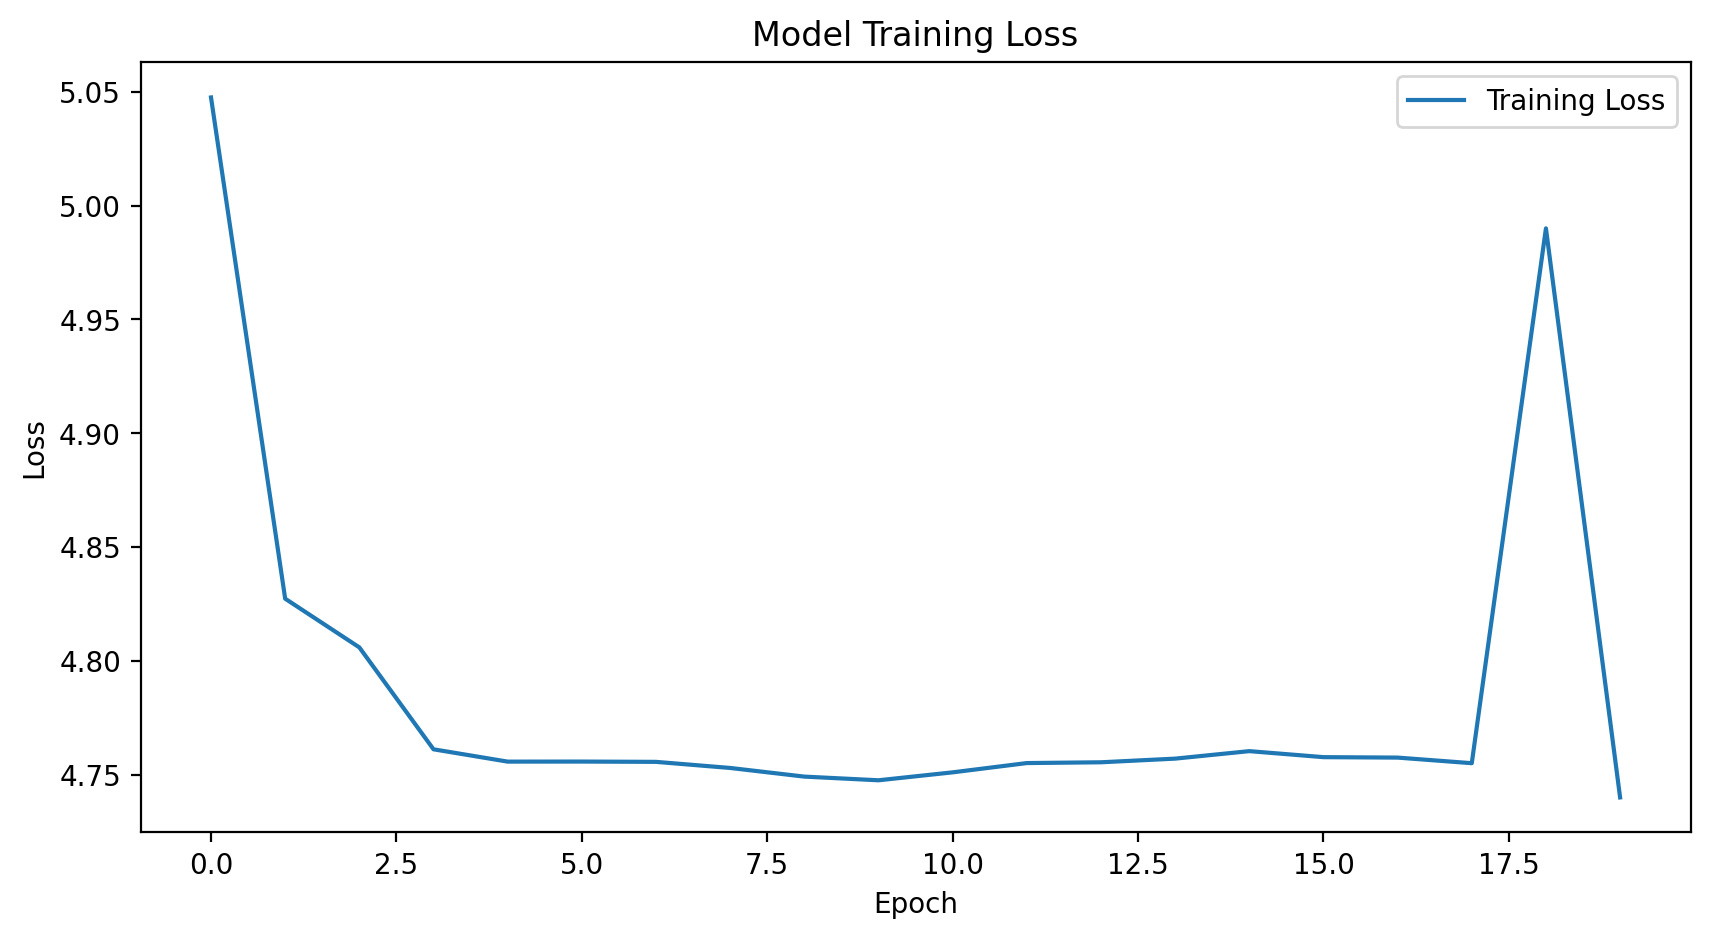

In [3]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create the LSTM neural network
model = LSTMModel(input_size=1, hidden_size=512, num_layers=2, output_size=n_vocab)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.01)

# Training the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')
    return train_losses

train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=20)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
torch.save(model.state_dict(), 'LSTM_model.pth')

In [27]:
# Function to generate music notes from the LSTM model
def generate_notes(model, network_input, n_vocab, sequence_length=100, num_notes=500):
    # Pick a random starting point for pattern generation
    start_index = np.random.randint(0, len(network_input) - 1)
    int_to_note = dict((number, note) for number, note in enumerate(set(all_notes)))
    pattern = network_input[start_index]

    # Initialize prediction output
    prediction_output = []

    # Generate notes
    model.eval()
    with torch.no_grad():
        for note_index in range(num_notes):
            # Reshape pattern to match LSTM input expectations
            prediction_input = torch.tensor(pattern, dtype=torch.float32).unsqueeze(0)
            
            # Adjust hidden state dimensions based on batch size
            batch_size = prediction_input.size(0)
            h0 = torch.zeros(model.num_layers, batch_size, model.hidden_size)
            c0 = torch.zeros(model.num_layers, batch_size, model.hidden_size)
            
            # Pass the input and hidden states to the model
            output, _ = model.lstm(prediction_input, (h0, c0))
            output = model.fc(output[:, -1, :])
            index = torch.argmax(output, dim=1).item()

            # Append the predicted note to the output
            predicted_note = int_to_note[index]
            prediction_output.append(predicted_note)

            # Update the pattern with the new note
            pattern = np.roll(pattern, -1, axis=1)  # Shift the pattern to the left
            pattern[0, -1] = index / float(n_vocab)  # Replace the last value with the new note

    return prediction_output
# Generate a sequence of notes
prediction_output_lstm = generate_notes(model, network_input, n_vocab)

# Create a MIDI file from the generated notes
output_notes_lstm = []
offset = 0

for pattern in prediction_output_lstm:
    # If the pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes_lstm.append(new_chord)
    # If the pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes_lstm.append(new_note)

    # Increase offset to prevent stacking of notes
    offset += 0.5

# Create a music stream and write it to a MIDI file
midi_stream_lstm = stream.Stream(output_notes_lstm)
midi_stream_lstm.write('midi', fp='LSTM_output.midi')


'LSTM_output.midi'